# CFT – ECG Analysis

## Setup and Helper Functions

In [1]:
import json
import re
from pathlib import Path

import pandas as pd
import numpy as np
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

from fau_colors import cmaps
import biopsykit as bp
from biopsykit.utils.dataframe_handling import multi_xs

from cft_analysis.datasets import CftDatasetProcessed

from IPython.display import Markdown

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties)
sns.set_theme(context="notebook", style="ticks", palette=palette)

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"

pg.options["round"] = 4

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

## Import Data

In [3]:
# get path to analysis results
base_path = Path("../../data")

In [4]:
results_path = base_path.joinpath("../results")
stats_path = results_path.joinpath("statistics")
tex_path = stats_path.joinpath("tex_tables")
bp.utils.file_handling.mkdirs([results_path, stats_path, tex_path])

paper_path = Path("../paper_path.json")
paper_tex_path = None
if paper_path.exists():
    paper_path = Path(json.load(paper_path.open(encoding="utf-8"))["paper_path"])
    paper_tex_path = paper_path.joinpath("tab")
    bp.utils.file_handling.mkdirs([paper_tex_path])

In [39]:
dataset = CftDatasetProcessed(base_path, exclude_subjects=True)
dataset

,condition,subject,phase,subphase
0,CFT,Vp01,MIST1,AT
1,CFT,Vp01,MIST1,AT
2,CFT,Vp01,MIST1,AT
3,CFT,Vp01,MIST1,AT
4,CFT,Vp01,MIST1,AT
...,...,...,...,...
4443,Control,Vp33,Post,Total
4444,Control,Vp33,Pre,Total
4445,Control,Vp33,Pre,Total
4446,Control,Vp33,Pre,Total


In [40]:
hue_order = ["Control", "CFT"]

## Response to the MIST

### Descriptive Analysis

To show the general efficacy of the MIST we compute the mean and maximum heart rate increase for each subject and MIST phase, respectively.  
Afterwards, we compute mean and standard deviation over all subjects:

In [119]:
hr_ensemble = dataset.heart_rate_ensemble
hr_ensemble = pd.DataFrame(hr_ensemble.stack(), columns=["data"]).join(dataset.condition_list)
hr_ensemble = hr_ensemble.reset_index().set_index(["condition", "phase", "time", "subject"])
hr_ensemble = hr_ensemble["data"].unstack(["subject", "condition"])
hr_ensemble.head()

subject          Vp01      Vp02       Vp04      Vp05       Vp15       Vp16  \
condition         CFT       CFT        CFT       CFT        CFT        CFT   
phase time                                                                   
MIST1 1     -8.317398 -0.412402   7.184292 -7.185016   9.180447 -15.601029   
      2     -3.720180 -4.127014  10.041075 -6.109130  14.538993 -13.528410   
      3     -5.866453 -8.723869   2.170225 -8.075388   4.105569 -19.610884   
      4     -9.985982 -8.748880  -3.774143 -3.142681  -7.994921 -23.350802   
      5    -11.751702 -3.616214 -12.368065 -9.587547  -9.542040 -24.727157   

subject          Vp18      Vp20      Vp25       Vp26  ...       Vp09  \
condition         CFT       CFT       CFT        CFT  ...    Control   
phase time                                            ...              
MIST1 1      2.743854 -8.664389  4.683156  -3.357802  ...  -7.818134   
      2      5.956126 -6.339915  2.560471  -4.909431  ...  -7.413341   
      3     11.966072 -4.329427  3.123288  -9.122872  ...  -2.236057   
      4      1.386065 -3.384193 -0.288092 -11.918682  ... -10.937985   
      5     -0.038145 -0.996683  5.123615 -12.620306  ...  -7.117339   

subject         Vp11      Vp17      Vp19       Vp21      Vp24      Vp30  \
condition    Control   Control   Control    Control   Control   Control   
phase time                                                                
MIST1 1     2.724037  1.743075  2.010397   3.328623 -7.181512  2.434562   
      2     3.339442 -0.058710 -0.131599   1.704383 -7.958105  3.777146   
      3     5.633895 -2.632612 -9.614859  19.556275 -7.720858 -2.844013   
      4     4.866643 -3.074540  1.220778  35.388658 -1.614905 -4.780654   
      5     2.432493  0.329262  1.085641  35.895015 -5.849688 -3.909095   

subject          Vp31       Vp32      Vp33  
condition     Control    Control   Control  
phase time                                  
MIST1 1    -11.582174  14.173981  2.532088  
      2    -12.787637  17.518175  6.446413  
      3    -10.203479   8.834447 -1.229008  
      4     -4.495005   6.735395 -2.398628  
      5     -7.902182   5.209966  1.205645  

[5 rows x 25 columns]

Max and mean HR increase over all participants

In [233]:
hr_increase = hr_ensemble.groupby(["phase"]).agg(["mean", "max"])
hr_increase = hr_increase.stack().agg(["mean", "std"], axis=1)
hr_increase.round(2)

mean    std
phase                   
MIST1 max   26.00  10.50
      mean  -1.98   5.38
MIST2 max   32.90  15.39
      mean   3.85  10.54
MIST3 max   39.02  17.13
      mean  10.32  12.85

Max and mean HR increase per condition

In [234]:
hr_increase = hr_ensemble.stack("condition").groupby(["condition", "phase"]).agg(["mean", "max"])
hr_increase = hr_increase.stack().agg(["mean", "std"], axis=1)
hr_increase.round(2).unstack()

mean           std       
                   max   mean    max   mean
condition phase                            
CFT       MIST1  20.18  -5.54   7.71   3.93
          MIST2  26.37  -1.38   9.21   5.55
          MIST3  30.96   3.73  11.14   7.35
Control   MIST1  31.37   1.30  10.06   4.39
          MIST2  38.92   8.68  17.72  11.89
          MIST3  46.46  16.40  18.67  14.04

Mean HR increase between BL and AT

In [235]:
hr_increase = dataset.heart_rate.reindex(["BL", "AT"], level="subphase").xs("HR_Norm", level="type")
hr_increase = hr_increase.unstack("subphase").diff(axis=1).stack()["data"]
hr_increase = hr_increase.groupby(["condition", "phase"]).agg(["mean", "std"])
hr_increase

mean        std
condition phase                      
CFT       MIST1   1.297985   5.596416
          MIST2   8.233201   6.980661
          MIST3  15.164477   8.092875
Control   MIST1   4.343706   4.729640
          MIST2  11.630294   9.986150
          MIST3  11.689753  10.947690

Latex Export

In [252]:
hr_increase_tex = hr_increase.copy()
hr_increase_tex = hr_increase_tex.round(2)
hr_increase_tex = hr_increase_tex.assign(
    **{
        r"data": hr_increase_tex.apply(lambda d: f"\SI{{{d['mean']} \pm {d['std']}}}{{\percent}}", axis=1)
    }
)
hr_increase_tex = hr_increase_tex.drop(columns=["mean", "std"])["data"]
hr_increase_tex.index = hr_increase_tex.index.rename([r"\textit{Condition}", r"\textit{Phase}"])
hr_increase_tex = hr_increase_tex.unstack(r"\textit{Condition}")

caption = "Heart Rate increase between BL and AT subphases for each individual MIST phase. Values are depicted as M $\pm$ SD."

tex_export = hr_increase_tex.style.to_latex(
    caption=caption, 
    column_format="l|SS", 
    position="h!",
    position_float="centering",
    hrules=True
)

for path in [tex_path, paper_tex_path]:
    if path is not None:
        path.joinpath("tab_hr_increase_bl_at.tex").open(mode="w+").write(tex_export)

### Statistical Analysis

**Population**: Control condition

**Analysis** (per measure):
1. *Increase BL-AT*: Check whether Arithmetic Tasks of the MIST causes significant HR(V) responses.
    * Procedure: Paired t-tests between subphases *BL* and *AT* for each MIST phase
    * Expected Result: Significant HR(V) responses for each MIST phase
2. *Increase over MIST*: Check whether the HR response increases over time (i.e., over MIST phases). 
    * Procedure: Repeated-measures ANOVA for each subphase
    * *(only for HR)*: Post-hoc test to check which pairs of MIST phases show significant differences
    * Expected Result: Significant main effect *MIST Phase* for each subphase


**Findings**: 
* Each MIST Phase induces stress, indicated by significant differences between $BL_{Loc}$ and $AT$ in each individual MIST Phase
* Stress levels increase over time, indicated by significant main effect *MIST Phase* and significant differences between MIST phases, especially between *MIST1* and *MIST3*

#### Increase BL-AT

In [9]:
display(Markdown("##### Prepare Data"))

condition = "Control"
subphases = ["BL", "AT"]
measures = ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]

hr_analysis = dataset.get_subset(condition=condition, subphase=subphases).hr_hrv
hr_analysis = multi_xs(hr_analysis, measures, level="type")

display(hr_analysis.head())


################################################
display(Markdown("##### Statistics"))

steps = [("prep", "normality"), ("test", "pairwise_tests")]
params = {
    "dv": "data",
    "within": "subphase",
    "subject": "subject",
    "groupby": ["type", "phase"],
    "multicomp": {"levels": "phase"},
}

stats = bp.stats.StatsPipeline(steps, params)
stats.apply(hr_analysis)

stats.export_statistics(stats_path.joinpath("stats_hrv_response_bl_at.xlsx"))
stats.display_results(prep=False)


################################################
display(Markdown("##### Latex Output"))

index_rename_map = {"HR_Norm": "$\Delta HR$", "HRV_RMSSD": "RMSSD", "HRV_pNN50": "pRR50"}

index_value_order = ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]

caption = "HR(V) responses to AT of the Control condition. \
Paired t-tests were performed between BL and AT subphases for each individual MIST phase.\
"

df_latex = stats.results_to_latex_table(
    "pairwise_tests",
    unstack_levels="phase",
    index_kws={
        "index_value_order": index_value_order,
        "index_rename_map": index_rename_map,
        "index_level_names_tex": ["Measure"],
    },
    caption=caption,
    label="tab:hrv_response_mist",
)

for path in [tex_path, paper_tex_path]:
    if path is not None:
        path.joinpath("tab_hrv_response_bl_at.tex").open(mode="w+").write(df_latex)
print(df_latex)

##### Prepare Data

data
condition subject phase subphase category type                
Control   Vp03    MIST1 AT       HR       HR_Norm     0.275049
                                 HRV      HRV_RMSSD  11.778790
                                          HRV_pNN50   0.242718
                        BL       HR       HR_Norm    -5.230397
                                 HRV      HRV_RMSSD  21.937769

##### Statistics

<font size="3"><b> Overview </b></font>

,dv,within,subject,groupby,multicomp
parameter,data,subphase,subject,"['type', 'phase']",{'levels': 'phase'}


,prep,test
parameter,normality,pairwise_tests


<font size="3"><b> Statistical Tests </b></font>

**Pairwise Tests**

Contrast   A   B  Paired  Parametric       T   dof  \
type      phase                                                         
HRV_RMSSD MIST1 0  subphase  AT  BL    True        True -1.2899  12.0   
          MIST2 0  subphase  AT  BL    True        True -3.1026  12.0   
          MIST3 0  subphase  AT  BL    True        True -1.9357  12.0   
HRV_pNN50 MIST1 0  subphase  AT  BL    True        True -0.7235  12.0   
          MIST2 0  subphase  AT  BL    True        True -2.7398  12.0   
          MIST3 0  subphase  AT  BL    True        True -1.1772  12.0   
HR_Norm   MIST1 0  subphase  AT  BL    True        True  3.3113  12.0   
          MIST2 0  subphase  AT  BL    True        True  4.1992  12.0   
          MIST3 0  subphase  AT  BL    True        True  3.8499  12.0   

                  alternative   p-unc    BF10  hedges  p-corr  
type      phase                                                
HRV_RMSSD MIST1 0   two-sided  0.2214   0.552 -0.2024  0.6642  
          MIST2 0   two-sided  0.0091   6.231 -0.5338  0.0273  
          MIST3 0   two-sided  0.0768   1.166 -0.3515  0.2304  
HRV_pNN50 MIST1 0   two-sided  0.4833   0.349 -0.0518  1.0000  
          MIST2 0   two-sided  0.0179   3.612 -0.4735  0.0537  
          MIST3 0   two-sided  0.2619   0.495 -0.2578  0.7857  
HR_Norm   MIST1 0   two-sided  0.0062   8.564  0.6553  0.0186  
          MIST2 0   two-sided  0.0012  33.143  0.8936  0.0036  
          MIST3 0   two-sided  0.0023  19.512  0.7616  0.0069

##### Latex Output

\begin{table}[th!]
\centering
\caption{HR(V) responses to AT of the Control condition. Paired t-tests were performed between BL and AT subphases for each individual MIST phase.}
\label{tab:hrv_response_mist}
\sisetup{table-format = <1.3}

\begin{tabular}{l||SSS|SSS|SSS}
\toprule
{} & \multicolumn{3}{c}{{MIST1}} & \multicolumn{3}{c}{{MIST2}} & \multicolumn{3}{c}{{MIST3}} \\
{} & {$t(12)$} &          {p} & {Hedges' g} & {$t(12)$} &           {p} & {Hedges' g} & {$t(12)$} &           {p} & {Hedges' g} \\
\textit{Measure}     &           &              &             &           &               &             &           &               &             \\
\midrule
\textit{$\Delta HR$} &     3.311 &  0.019$^{*}$ &       0.655 &     4.199 &  0.004$^{**}$ &       0.894 &     3.850 &  0.007$^{**}$ &       0.762 \\
\textit{RMSSD}       &    -1.290 &   0.664$^{}$ &      -0.202 &    -3.103 &   0.027$^{*}$ &      -0.534 &    -1.936 &    0.230$^{}$ &      -0.351 \\
\textit{pRR50}       &    -0.724 &  >

/Users/Richer/Documents/PhD/Projects/HealthPsychology/ColdFaceTest/Code/cft_analysis/.venv/lib/python3.8/site-packages/biopsykit/stats/stats.py:795: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data_latex = data.to_latex(**kwargs)


#### Increase over MIST

In [10]:
display(Markdown("##### Prepare Data"))

measures = ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]
subphases = ["BL", "AT", "FB"]
conditions = ["Control"]

hr_analysis = dataset.get_subset(condition=conditions, subphase=subphases).hr_hrv

# Select data
hr_analysis = multi_xs(hr_analysis, measures, level="type")
display(hr_analysis.head())

#################################################################
display(Markdown("##### Statistics"))

steps = [("prep", "normality"), ("prep", "equal_var"), ("test", "rm_anova"), ("posthoc", "pairwise_tests")]
params = {
    "dv": "data",
    "within": "phase",
    "subject": "subject",
    "groupby": ["subphase", "type"],
    "multicomp": {"levels": False},
    "test__effsize": "np2",
}

stats = bp.stats.StatsPipeline(steps, params)
stats.apply(hr_analysis)

stats.export_statistics(stats_path.joinpath("stats_hrv_response_mist_phases.xlsx"))
stats.display_results(prep=True)  # , sig_only="posthoc")

#################################################################
display(Markdown("##### Latex Output"))

#################################################################
display(Markdown("##### RM-ANOVA over Phase during BL, AT, and FB"))

caption = "HR(V) measures of the Control condition over the course of the MIST phases. \
Repeated-measurement ANOVAs were performed separately for BL, AT, and FB subphases with MIST phase as within-variable."

index_value_order = {"type": ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"], "subphase": ["BL", "AT", "FB"]}
index_rename_map = {"HR_Norm": "$\Delta HR$", "HRV_RMSSD": "RMSSD", "HRV_pNN50": "pRR50"}

df_latex = stats.results_to_latex_table(
    "rm_anova",
    unstack_levels=["subphase"],
    index_kws={
        "index_value_order": index_value_order,
        "index_rename_map": index_rename_map,
        "index_level_names_tex": ["Measure"],
    },
    caption=caption,
    label="tab:hrv_increase_mist",
    multicolumn_format="c",
    escape=False,
    multirow=True,
)


#################################################################
display(Markdown("##### Post-hoc (Supplementary Information)"))

caption = "Posthoc results of HR(V) measures during the MIST. Pairwise t-tests were performed separately \
for BL, AT, and FB subphases between pairs of MIST phases."

index_value_order = {"subphase": ["BL", "AT", "FB"]}
column_value_order = {"type": ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]}
column_rename_map = {"HR_Norm": "$\Delta HR$", "HRV_RMSSD": "RMSSD", "HRV_pNN50": "pRR50"}

df_latex_posthoc = stats.results_to_latex_table(
    "pairwise_tests",
    unstack_levels=["type"],
    show_a_b=True,
    column_kws={"column_value_order": column_value_order, "column_rename_map": column_rename_map},
    index_kws={
        "index_value_order": index_value_order,
        "index_level_names_tex": ["Subphase", "A", "B"],
    },
    caption=caption,
    label="tab:hrv_increase_mist_posthoc",
    multirow=True,
    collapse_dof=True,
    position="h",
)

print(stats.stats_to_latex("pairwise_tests"))

for path in [tex_path, paper_tex_path]:
    if path is not None:
        path.joinpath("tab_hrv_response_mist_phases.tex").open(mode="w+").write(df_latex)
        path.joinpath("tab_hrv_response_mist_phases_posthoc.tex").open(mode="w+").write(df_latex_posthoc)

##### Prepare Data

data
condition subject phase subphase category type                
Control   Vp03    MIST1 AT       HR       HR_Norm     0.275049
                                 HRV      HRV_RMSSD  11.778790
                                          HRV_pNN50   0.242718
                        BL       HR       HR_Norm    -5.230397
                                 HRV      HRV_RMSSD  21.937769

##### Statistics

<font size="3"><b> Overview </b></font>

,dv,within,subject,groupby,multicomp,test__effsize
parameter,data,phase,subject,"['subphase', 'type']",{'levels': False},np2


,prep,prep,test,posthoc
parameter,normality,equal_var,rm_anova,pairwise_tests


<font size="3"><b> Preparatory Analysis </b></font>

**Test for Normal Distribution**

W    pval  normal
subphase type                                   
AT       HRV_RMSSD MIST1  0.9513  0.6184    True
                   MIST2  0.9496  0.5926    True
                   MIST3  0.9317  0.3590    True
         HRV_pNN50 MIST1  0.9086  0.1754    True
                   MIST2  0.8782  0.0674    True
                   MIST3  0.8372  0.0195   False
         HR_Norm   MIST1  0.9534  0.6503    True
                   MIST2  0.7528  0.0020   False
                   MIST3  0.9204  0.2539    True
BL       HRV_RMSSD MIST1  0.8837  0.0802    True
                   MIST2  0.8520  0.0303   False
                   MIST3  0.9191  0.2436    True
         HRV_pNN50 MIST1  0.9026  0.1454    True
                   MIST2  0.8868  0.0882    True
                   MIST3  0.8326  0.0171   False
         HR_Norm   MIST1  0.9245  0.2883    True
                   MIST2  0.9617  0.7798    True
                   MIST3  0.8944  0.1122    True
FB       HRV_RMSSD MIST1  0.9660  0.8421    True
                   MIST2  0.9711  0.9067    True
                   MIST3  0.9107  0.1877    True
         HRV_pNN50 MIST1  0.9435  0.5043    True
                   MIST2  0.9374  0.4238    True
                   MIST3  0.8558  0.0339   False
         HR_Norm   MIST1  0.9190  0.2430    True
                   MIST2  0.7566  0.0022   False
                   MIST3  0.9212  0.2602    True

**Test for Homoscedasticity (Equal Variances)**

W    pval  equal_var
subphase type                                       
AT       HRV_RMSSD levene  0.1715  0.8431       True
         HRV_pNN50 levene  0.9638  0.3911       True
         HR_Norm   levene  3.3801  0.0452      False
BL       HRV_RMSSD levene  0.1639  0.8495       True
         HRV_pNN50 levene  0.2318  0.7943       True
         HR_Norm   levene  1.2748  0.2918       True
FB       HRV_RMSSD levene  0.0518  0.9495       True
         HRV_pNN50 levene  0.3082  0.7367       True
         HR_Norm   levene  1.2484  0.2991       True

<font size="3"><b> Statistical Tests </b></font>

**Repeated-measurement ANOVA**

Source  ddof1  ddof2       F   p-unc     np2     eps  \
subphase type                                                               
AT       HRV_RMSSD 0  phase      2     24  8.3585  0.0018  0.4106  0.9129   
         HRV_pNN50 0  phase      2     24  8.1893  0.0019  0.4056  0.8491   
         HR_Norm   0  phase      2     24  9.1600  0.0011  0.4329  0.9646   
BL       HRV_RMSSD 0  phase      2     24  2.4660  0.1062  0.1705  0.9172   
         HRV_pNN50 0  phase      2     24  1.8156  0.1844  0.1314  0.9056   
         HR_Norm   0  phase      2     24  7.9027  0.0023  0.3971  0.9637   
FB       HRV_RMSSD 0  phase      2     24  7.3983  0.0031  0.3814  0.8670   
         HRV_pNN50 0  phase      2     24  1.8550  0.1782  0.1339  0.6301   
         HR_Norm   0  phase      2     24  9.2494  0.0011  0.4353  0.7786   

                      p-GG-corr sphericity  W-spher  p-spher  
subphase type                                                 
AT       HRV_RMSSD 0        NaN        NaN      NaN      NaN  
         HRV_pNN50 0        NaN        NaN      NaN      NaN  
         HR_Norm   0        NaN        NaN      NaN      NaN  
BL       HRV_RMSSD 0        NaN        NaN      NaN      NaN  
         HRV_pNN50 0        NaN        NaN      NaN      NaN  
         HR_Norm   0        NaN        NaN      NaN      NaN  
FB       HRV_RMSSD 0        NaN        NaN      NaN      NaN  
         HRV_pNN50 0     0.1945      False   0.4129   0.0077  
         HR_Norm   0        NaN        NaN      NaN      NaN

<font size="3"><b> Post-Hoc Analysis </b></font>

**Pairwise Tests**

Contrast      A      B  Paired  Parametric       T   dof  \
subphase type                                                                   
AT       HRV_RMSSD 0    phase  MIST1  MIST2    True        True  2.7194  12.0   
                   1    phase  MIST1  MIST3    True        True  3.5877  12.0   
                   2    phase  MIST2  MIST3    True        True  1.3972  12.0   
         HRV_pNN50 0    phase  MIST1  MIST2    True        True  2.8786  12.0   
                   1    phase  MIST1  MIST3    True        True  3.3882  12.0   
                   2    phase  MIST2  MIST3    True        True  0.9337  12.0   
         HR_Norm   0    phase  MIST1  MIST2    True        True -2.8317  12.0   
                   1    phase  MIST1  MIST3    True        True -4.1871  12.0   
                   2    phase  MIST2  MIST3    True        True -1.5710  12.0   
BL       HRV_RMSSD 0    phase  MIST1  MIST2    True        True  0.3171  12.0   
                   1    phase  MIST1  MIST3    True        True  1.8607  12.0   
                   2    phase  MIST2  MIST3    True        True  1.7031  12.0   
         HRV_pNN50 0    phase  MIST1  MIST2    True        True  0.5274  12.0   
                   1    phase  MIST1  MIST3    True        True  1.7678  12.0   
                   2    phase  MIST2  MIST3    True        True  1.2447  12.0   
         HR_Norm   0    phase  MIST1  MIST2    True        True -1.3782  12.0   
                   1    phase  MIST1  MIST3    True        True -4.0193  12.0   
                   2    phase  MIST2  MIST3    True        True -2.3987  12.0   
FB       HRV_RMSSD 0    phase  MIST1  MIST2    True        True  0.8470  12.0   
                   1    phase  MIST1  MIST3    True        True  3.1000  12.0   
                   2    phase  MIST2  MIST3    True        True  3.2918  12.0   
         HRV_pNN50 0    phase  MIST1  MIST2    True        True  0.9734  12.0   
                   1    phase  MIST1  MIST3    True        True  1.4420  12.0   
                   2    phase  MIST2  MIST3    True        True  1.4801  12.0   
         HR_Norm   0    phase  MIST1  MIST2    True        True -1.9363  12.0   
                   1    phase  MIST1  MIST3    True        True -3.5281  12.0   
                   2    phase  MIST2  MIST3    True        True -2.7546  12.0   

                     alternative   p-unc    BF10  hedges  p-corr  
subphase type                                                     
AT       HRV_RMSSD 0   two-sided  0.0186   3.504  0.4796  0.0558  
                   1   two-sided  0.0037  13.071  0.6576  0.0111  
                   2   two-sided  0.1877   0.616  0.2044  0.5631  
         HRV_pNN50 0   two-sided  0.0139   4.443  0.5318  0.0417  
                   1   two-sided  0.0054   9.632  0.6618  0.0162  
                   2   two-sided  0.3689   0.403  0.1446  1.0000  
         HR_Norm   0   two-sided  0.0151   4.141 -0.8920  0.0453  
                   1   two-sided  0.0013  32.546 -1.3317  0.0039  
                   2   two-sided  0.1422   0.746 -0.4142  0.4266  
BL       HRV_RMSSD 0   two-sided  0.7566   0.291  0.0502  1.0000  
                   1   two-sided  0.0875   1.059  0.4388  0.2625  
                   2   two-sided  0.1143   0.871  0.3808  0.3429  
         HRV_pNN50 0   two-sided  0.6075   0.314  0.0902  1.0000  
                   1   two-sided  0.1025   0.943  0.3767  0.3075  
                   2   two-sided  0.2370   0.528  0.3011  0.7110  
         HR_Norm   0   two-sided  0.1933   0.604 -0.4111  0.5799  
                   1   two-sided  0.0017  25.248 -1.0276  0.0051  
                   2   two-sided  0.0336   2.196 -0.6432  0.1008  
FB       HRV_RMSSD 0   two-sided  0.4136   0.378  0.1045  1.0000  
                   1   two-sided  0.0092   6.206  0.5136  0.0276  
                   2   two-sided  0.0064   8.312  0.3832  0.0192  
         HRV_pNN50 0   two-sided  0.3496   0.415  0.1297  1.0000  
                   1   two-sided  0.1749   0.646  0.3004  0.524

##### Latex Output

##### RM-ANOVA over Phase during BL, AT, and FB

/Users/Richer/Documents/PhD/Projects/HealthPsychology/ColdFaceTest/Code/cft_analysis/.venv/lib/python3.8/site-packages/biopsykit/stats/stats.py:795: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data_latex = data.to_latex(**kwargs)


##### Post-hoc (Supplementary Information)

subphase  type          Contrast  A      B    
AT        HRV_RMSSD  0  phase     MIST1  MIST2      $t(12) = 2.719, p = 0.056, g = 0.480$
                     1  phase     MIST1  MIST3      $t(12) = 3.588, p = 0.011, g = 0.658$
                     2  phase     MIST2  MIST3      $t(12) = 1.397, p = 0.563, g = 0.204$
          HRV_pNN50  0  phase     MIST1  MIST2      $t(12) = 2.879, p = 0.042, g = 0.532$
                     1  phase     MIST1  MIST3      $t(12) = 3.388, p = 0.016, g = 0.662$
                     2  phase     MIST2  MIST3      $t(12) = 0.934, p > 0.999, g = 0.145$
          HR_Norm    0  phase     MIST1  MIST2    $t(12) = -2.832, p = 0.045, g = -0.892$
                     1  phase     MIST1  MIST3    $t(12) = -4.187, p = 0.004, g = -1.332$
                     2  phase     MIST2  MIST3    $t(12) = -1.571, p = 0.427, g = -0.414$
BL        HRV_RMSSD  0  phase     MIST1  MIST2      $t(12) = 0.317, p > 0.999, g = 0.050$
                     1  phase     MIST1  MIST3      $

/Users/Richer/Documents/PhD/Projects/HealthPsychology/ColdFaceTest/Code/cft_analysis/.venv/lib/python3.8/site-packages/biopsykit/stats/stats.py:795: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data_latex = data.to_latex(**kwargs)


## Response to the CFT

In [11]:
features = ["onset_latency", "peak_brady_latency", "peak_brady_percent", "mean_brady_percent"]

### Descriptive Analysis

In [12]:
cft_analysis = dataset.cft_parameter
cft_analysis.head()

data
condition subject phase subphase category type                         
CFT       Vp01    MIST1 Total    CFT      baseline_hr         92.059566
                                          cft_start_idx       93.000000
                                          mean_brady_bpm      -7.348546
                                          mean_brady_percent  -7.982382
                                          mean_hr_bpm         84.711019

In [13]:
cft_analysis = multi_xs(cft_analysis, features, level="type")
cft_analysis_agg = cft_analysis.unstack()["data"]

cft_analysis_agg = (
    cft_analysis_agg.groupby("phase")
    .agg(
        {
            "onset_latency": ["mean", "std"],
            "peak_brady_latency": ["mean", "std"],
            "peak_brady_percent": ["min", "mean", "std"],
            "mean_brady_percent": ["min", "mean", "std"],
        }
    )
    .T
)
cft_analysis_agg

phase                        MIST1      MIST2      MIST3
type                                                    
onset_latency      mean   7.525250   4.307167  12.229667
                   std    8.748095   4.555121   6.752471
peak_brady_latency mean  50.941250  47.746250  53.456500
                   std   29.898792  34.009036  32.137150
peak_brady_percent min  -26.617372 -23.891467 -20.651473
                   mean -18.773242 -16.589792 -12.261732
                   std    4.833408   4.170970   3.874516
mean_brady_percent min  -15.320881 -11.770874  -7.061865
                   mean  -6.192499  -3.939586  -0.836625
                   std    5.430712   4.655319   4.315025

In [14]:
cft_time_bl_glo = dataset.get_subset(condition="CFT", subphase="RP_CFI").time_above_baseline
cft_time_bl_glo = cft_time_bl_glo.xs("HR", level="type")
cft_time_bl_glo = cft_time_bl_glo.groupby("phase").agg(["mean", "std"]).T
cft_time_bl_glo.round(2)

phase      MIST1  MIST2  MIST3
data mean   9.39  10.20  20.12
     std   15.27   8.98  17.51

### Statistical Analysis

**Population**: CFT condition  
**Analysis** (per measure):
1. *Decrease BL-RP_CFI*: Check whether Cold Face Intervention causes significant HR(V) responses.
    * Procedure: Paired t-tests between subphases *BL* and *RP_CFI* for each MIST phase
    * Expected Result: Significant HR(V) responses during each MIST phase


**Findings**: 
* Each MIST Phase induces stress, indicated by significant differences between $BL_{Loc}$ and $AT$ in each individual MIST Phase
* Stress levels increase over time, indicated by significant main effect *MIST Phase* and significant differences between MIST phases, especially between *MIST1* and *MIST3*

#### Decrease *BL-RP_CFI*

In [15]:
display(Markdown("##### Prepare Data"))

subphases = ["BL", "RP_CFI"]
conditions = ["CFT"]
measures = ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]

hr_analysis = dataset.get_subset(condition=conditions, subphase=subphases).hr_hrv
hr_analysis = multi_xs(hr_analysis, measures, level="type")
display(hr_analysis.head())

################################################################
display(Markdown("##### Statistics"))

steps = [("prep", "normality"), ("test", "pairwise_tests")]
params = {
    "dv": "data",
    "within": "subphase",
    "subject": "subject",
    "groupby": ["type", "phase"],
    "multicomp": {"levels": "phase"},
}

stats = bp.stats.StatsPipeline(steps, params)
stats.apply(hr_analysis)

stats.export_statistics(stats_path.joinpath("stats_hr_response_bl_cfi.xlsx"))
stats.display_results(prep=False)

################################################################
display(Markdown("##### Latex Output"))

index_rename_map = {"HR_Norm": "$\Delta HR$", "HRV_RMSSD": "RMSSD", "HRV_pNN50": "pRR50"}

index_value_order = ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]

caption = "HR(V) responses of the CFT condition to the Cold Face Test. \
Paired t-tests were performed between BL and RP/CFI subphases for each MIST phase separately."

df_latex = stats.results_to_latex_table(
    "pairwise_tests",
    unstack_levels="phase",
    index_kws={
        "index_value_order": index_value_order,
        "index_rename_map": index_rename_map,
        "index_level_names_tex": ["Measure"],
    },
    caption=caption,
    label="tab:hrv_response_cft",
)

for path in [tex_path, paper_tex_path]:
    if path is not None:
        path.joinpath("tab_hrv_response_bl_cfi.tex").open(mode="w+").write(df_latex)
print(df_latex)

##### Prepare Data

data
condition subject phase subphase category type                
CFT       Vp01    MIST1 BL       HR       HR_Norm    -4.845864
                                 HRV      HRV_RMSSD  23.746673
                                          HRV_pNN50   2.173913
                        RP_CFI   HR       HR_Norm   -12.341485
                                 HRV      HRV_RMSSD  30.683488

##### Statistics

<font size="3"><b> Overview </b></font>

,dv,within,subject,groupby,multicomp
parameter,data,subphase,subject,"['type', 'phase']",{'levels': 'phase'}


,prep,test
parameter,normality,pairwise_tests


<font size="3"><b> Statistical Tests </b></font>

**Pairwise Tests**

Contrast   A       B  Paired  Parametric       T   dof  \
type      phase                                                             
HRV_RMSSD MIST1 0  subphase  BL  RP_CFI    True        True -2.6815  11.0   
          MIST2 0  subphase  BL  RP_CFI    True        True -1.4346  11.0   
          MIST3 0  subphase  BL  RP_CFI    True        True -1.2136  11.0   
HRV_pNN50 MIST1 0  subphase  BL  RP_CFI    True        True -3.1493  11.0   
          MIST2 0  subphase  BL  RP_CFI    True        True -1.2922  11.0   
          MIST3 0  subphase  BL  RP_CFI    True        True -3.1291  11.0   
HR_Norm   MIST1 0  subphase  BL  RP_CFI    True        True  3.8449  11.0   
          MIST2 0  subphase  BL  RP_CFI    True        True  2.9717  11.0   
          MIST3 0  subphase  BL  RP_CFI    True        True  0.6733  11.0   

                  alternative   p-unc    BF10  hedges  p-corr  
type      phase                                                
HRV_RMSSD MIST1 0   two-sided  0.0214   3.219 -0.4877  0.0642  
          MIST2 0   two-sided  0.1792   0.655 -0.1761  0.5376  
          MIST3 0   two-sided  0.2503   0.526 -0.1433  0.7509  
HRV_pNN50 MIST1 0   two-sided  0.0093   6.302 -0.5429  0.0279  
          MIST2 0   two-sided  0.2228   0.567 -0.1737  0.6684  
          MIST3 0   two-sided  0.0096    6.12 -0.4148  0.0288  
HR_Norm   MIST1 0   two-sided  0.0027  17.267  1.2551  0.0081  
          MIST2 0   two-sided  0.0127   4.875  0.9477  0.0381  
          MIST3 0   two-sided  0.5147   0.349  0.1675  1.0000

##### Latex Output

\begin{table}[th!]
\centering
\caption{HR(V) responses of the CFT condition to the Cold Face Test. Paired t-tests were performed between BL and RP/CFI subphases for each MIST phase separately.}
\label{tab:hrv_response_cft}
\sisetup{table-format = <1.3}

\begin{tabular}{l||SSS|SSS|SSS}
\toprule
{} & \multicolumn{3}{c}{{MIST1}} & \multicolumn{3}{c}{{MIST2}} & \multicolumn{3}{c}{{MIST3}} \\
{} & {$t(11)$} &           {p} & {Hedges' g} & {$t(11)$} &          {p} & {Hedges' g} & {$t(11)$} &          {p} & {Hedges' g} \\
\textit{Measure}     &           &               &             &           &              &             &           &              &             \\
\midrule
\textit{$\Delta HR$} &     3.845 &  0.008$^{**}$ &       1.255 &     2.972 &  0.038$^{*}$ &       0.948 &     0.673 &  >0.999$^{}$ &       0.168 \\
\textit{RMSSD}       &    -2.682 &    0.064$^{}$ &      -0.488 &    -1.435 &   0.538$^{}$ &      -0.176 &    -1.214 &   0.751$^{}$ &      -0.143 \\
\textit{pRR50}       &    

/Users/Richer/Documents/PhD/Projects/HealthPsychology/ColdFaceTest/Code/cft_analysis/.venv/lib/python3.8/site-packages/biopsykit/stats/stats.py:795: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data_latex = data.to_latex(**kwargs)


## Effect of CFT on Acute Stress Response

### Statistical Analysis

#### Interaction Condition x MIST

**Population**: Control vs. CFT condition  

**Analysis** (per measure):
1. *Interaction Condition x MIST Phase*: Check whether Cold Face Intervention has an effect on the HR(V) responses to the MIST.
    * Procedure:
        * Mixed-ANOVA to determine interaction effect between *Condition* and *MIST Phase*
        * In case of significant interaction effect: Post-hoc test to assess during which MIST Phase the conditions showed HR(V) response differences
    * Expected Result: Significant interaction effect between *Condition* and *MIST Phase*


**Findings**: 
* Each MIST Phase induces stress, indicated by significant differences between $BL_{Loc}$ and $AT$ in each individual MIST Phase
* Stress levels increase over time, indicated by significant main effect *MIST Phase* and significant differences between MIST phases, especially between *MIST1* and *MIST3*

In [16]:
display(Markdown("##### Prepare Data"))

phases = ["MIST1", "MIST2", "MIST3"]
subphases = ["BL", "RP_CFI"]
hr_measures = ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]
time_bl_measures = ["HR", "HRV_RMSSD", "HRV_pNN50"]

hr_analysis = dataset.get_subset(phase=phases, subphase=subphases).hr_hrv
hr_analysis = multi_xs(hr_analysis, hr_measures, level="type")
time_bl_analysis = dataset.get_subset(phase=phases, subphase=subphases).time_above_baseline
time_bl_analysis = multi_xs(time_bl_analysis, time_bl_measures, level="type")

hr_analysis = hr_analysis.unstack(["type", "category"]).join(time_bl_analysis.unstack(["type", "category"]))
hr_analysis = hr_analysis.stack(["category", "type"])
display(hr_analysis.head())


#################################################################
display(Markdown("##### Statistics"))

steps = [("prep", "normality"), ("prep", "equal_var"), ("test", "mixed_anova"), ("posthoc", "pairwise_tests")]
params = {
    "dv": "data",
    "within": "phase",
    "between": "condition",
    "subject": "subject",
    "groupby": ["category", "type", "subphase"],
    "padjust": "bonf",
}

stats = bp.stats.StatsPipeline(steps, params)
stats.apply(hr_analysis)

stats.export_statistics(stats_path.joinpath("stats_effect_cft_interaction.xlsx"))
stats.display_results(prep=False, posthoc=True, sig_only=["test", "posthoc"])

#################################################################
display(Markdown("##### Latex Output"))

index_rename_map = {
    "HR_HR_Norm": "$\Delta HR$",
    "HRV_HRV_RMSSD": "RMSSD",
    "HRV_HRV_pNN50": "pRR50",
    "RP_CFI": "RP/CFI",
    "Time_BL_Glo_HR": "$\hat{t}_{Glo}(HR)$",
    "Time_BL_Glo_HRV_RMSSD": "$\hat{t}_{Glo}(RMSSD)$",
    "Time_BL_Glo_HRV_pNN50": "$\hat{t}_{Glo}(pRR50)$",
}

index_value_order = {
    "type": [
        "HR_HR_Norm",
        "Time_BL_Glo_HR",
        "HRV_HRV_RMSSD",
        "Time_BL_Glo_HRV_RMSSD",
        "HRV_HRV_pNN50",
        "Time_BL_Glo_HRV_pNN50",
    ]
}

#################################################################
display(Markdown("##### Interaction Effect Phase x Condition during BL"))

data = stats.results["mixed_anova"]
data = data.xs("BL", level="subphase")
data = data.unstack(-1)
data.index = ["_".join(val) for val in data.index]
data.index.names = ["type"]
data = data.stack(-1)

caption = "Mixed-ANOVA results (interaction effect MIST Phase x Condition) of HR(V) measures during BL subphase."

df_latex_interaction = stats.results_to_latex_table(
    "mixed_anova",
    data=data,
    stats_effect_type="Interaction",
    collapse_dof=True,
    index_kws={
        "index_value_order": index_value_order,
        "index_rename_map": index_rename_map,
        "index_level_names_tex": ["Measure"],
    },
    caption=caption,
    label="tab:cft_mist_interaction_bl",
)
print(df_latex_interaction)

#################################################################
display(Markdown("##### Interaction Effect Phase x Condition during RP/CFI (Supplementary Information)"))

data = stats.results["mixed_anova"]
data = data.xs("RP_CFI", level="subphase")
data = data.unstack(-1)
data.index = ["_".join(val) for val in data.index]
data.index.names = ["type"]
data = data.stack(-1)

caption = "Mixed-ANOVA results (interaction effect MIST Phase x Condition) of HR(V) measures during RP/CFI subphase."

df_latex_interaction_suppl = stats.results_to_latex_table(
    "mixed_anova",
    data=data,
    stats_effect_type="Interaction",
    collapse_dof=True,
    index_kws={
        "index_value_order": index_value_order,
        "index_rename_map": index_rename_map,
        "index_level_names_tex": ["Measure"],
    },
    caption=caption,
    label="tab:cft_mist_interaction_rp_cfi",
)
print(df_latex_interaction_suppl)

#################################################################
display(Markdown("##### Main Effect Condition during RP/CFI"))

data = stats.results["mixed_anova"]
data = data.xs("RP_CFI", level="subphase")
data = data.unstack(-1)
data.index = ["_".join(val) for val in data.index]
data.index.names = ["type"]
data = data.stack(-1)

caption = "Mixed-ANOVA results (main effect Condition) of HR(V) measures during RP/CFI subphase."

df_latex_main = stats.results_to_latex_table(
    "mixed_anova",
    data=data,
    stats_effect_type="condition",
    index_kws={
        "index_value_order": index_value_order,
        "index_rename_map": index_rename_map,
        "index_level_names_tex": ["Measure"],
    },
    caption=caption,
    label="tab:cft_mist_main_effect_condition",
)
print(df_latex_main)

################## SUPPLEMENTARY INFORMATION #######################
display(Markdown("##### Post-Hoc Interaction Effect Phase x Condition during BL (Supplementary Information)"))

posthoc_results = stats._filter_effect("posthoc", "interaction")
posthoc_results = posthoc_results.xs("BL", level="subphase")
posthoc_results = posthoc_results.unstack(-1)
posthoc_results.index = ["_".join(val) for val in posthoc_results.index]
posthoc_results.index.names = ["type"]
posthoc_results = posthoc_results.stack(-1)
posthoc_results = posthoc_results.set_index("phase", append=True)
posthoc_results = posthoc_results.reorder_levels(["type", "phase", None])

caption = "Post-hoc results (interaction effect MIST Phase x Condition) \
of HR(V) measures during BL subphase. Pairwise t-tests were performed for each MIST phase between Control and CFT condition."

df_latex_posthoc = stats.results_to_latex_table(
    "pairwise_tests",
    data=posthoc_results,
    unstack_levels="phase",
    collapse_dof=False,
    index_kws={
        "index_value_order": index_value_order,
        "index_rename_map": index_rename_map,
        "index_level_names_tex": ["Measure"],
    },
    caption=caption,
    label="tab:cft_mist_posthoc",
)
print(df_latex_posthoc)

for path in [tex_path, paper_tex_path]:
    if path is not None:
        path.joinpath("tab_hrv_response_cft_interaction_bl.tex").open(mode="w+").write(df_latex_interaction)
        path.joinpath("tab_hrv_response_cft_main_effect_condition.tex").open(mode="w+").write(df_latex_main)
        path.joinpath("tab_hrv_response_cft_posthoc.tex").open(mode="w+").write(df_latex_posthoc)
        path.joinpath("tab_hrv_response_cft_interaction_rp_cfi.tex").open(mode="w+").write(df_latex_interaction_suppl)

print(stats.stats_to_latex(data=posthoc_results))

##### Prepare Data

data
condition subject phase subphase category    type                
CFT       Vp01    MIST1 BL       HR          HR_Norm    -4.845864
                                 HRV         HRV_RMSSD  23.746673
                                             HRV_pNN50   2.173913
                                 Time_BL_Glo HR         22.580645
                                             HRV_RMSSD  69.892473

##### Statistics

<font size="3"><b> Overview </b></font>

,dv,within,between,subject,groupby,padjust
parameter,data,phase,condition,subject,"['category', 'type', 'subphase']",bonf


,prep,prep,test,posthoc
parameter,normality,equal_var,mixed_anova,pairwise_tests


<font size="3"><b> Statistical Tests </b></font>

**Mixed ANOVA**

Source          SS  DF1  DF2  \
category    type      subphase                                        
HR          HR_Norm   BL       0    condition   1366.2326    1   23   
                               1        phase    363.8055    2   46   
                               2  Interaction    370.3966    2   46   
                      RP_CFI   0    condition   2956.6659    1   23   
                               1        phase    854.6626    2   46   
Time_BL_Glo HR        BL       0    condition  12251.2716    1   23   
                               1        phase   3819.0293    2   46   
                               2  Interaction   2788.8848    2   46   
                      RP_CFI   0    condition  32257.8113    1   23   
                               1        phase   7808.4064    2   46   
                               2  Interaction   1971.8838    2   46   
            HRV_RMSSD RP_CFI   0    condition  14365.2037    1   23   
            HRV_pNN50 RP_CFI   0    condition  11324.8697    1   23   

                                          MS        F   p-unc     np2     eps  \
category    type      subphase                                                  
HR          HR_Norm   BL       0   1366.2326  12.4245  0.0018  0.3507     NaN   
                               1    181.9028   6.1499  0.0043  0.2110  0.9630   
                               2    185.1983   6.2613  0.0039  0.2140     NaN   
                      RP_CFI   0   2956.6659  34.0692  0.0000  0.5970     NaN   
                               1    427.3313  15.3479  0.0000  0.4002  0.7766   
Time_BL_Glo HR        BL       0  12251.2716  13.8897  0.0011  0.3765     NaN   
                               1   1909.5146   4.7562  0.0133  0.1714  0.9992   
                               2   1394.4424   3.4733  0.0394  0.1312     NaN   
                      RP_CFI   0  32257.8113  76.3949  0.0000  0.7686     NaN   
                               1   3904.2032  13.3388  0.0000  0.3671  0.9064   
                               2    985.9419   3.3685  0.0431  0.1277     NaN   
            HRV_RMSSD RP_CFI   0  14365.2037  14.4425  0.0009  0.3857     NaN   
            HRV_pNN50 RP_CFI   0  11324.8697   7.6740  0.0109  0.2502     NaN   

                                  p-GG-corr sphericity  W-spher  p-spher  
category    type      subphase                                            
HR          HR_Norm   BL       0        NaN        NaN      NaN      NaN  
                               1        NaN        NaN      NaN      NaN  
                               2        NaN        NaN      NaN      NaN  
                      RP_CFI   0        NaN        NaN      NaN      NaN  
                               1     0.0001      False   0.7123   0.0202  
Time_BL_Glo HR        BL       0        NaN        NaN      NaN      NaN  
                               1        NaN        NaN      NaN      NaN  
                               2        NaN        NaN      NaN      NaN  
                      RP_CFI   0        NaN        NaN      NaN      NaN  
                               1        NaN        NaN      NaN      NaN  
                               2        NaN        NaN      NaN      NaN  
            HRV_RMSSD RP_CFI   0        NaN        NaN      NaN      NaN  
            HRV_pNN50 RP_CFI   0        NaN        NaN      NaN      NaN

<font size="3"><b> Post-Hoc Analysis </b></font>

**Pairwise Tests**

Contrast  phase      A        B  \
category    type      subphase                                               
HR          HR_Norm   BL       1              phase      -  MIST1    MIST3   
                               5  phase * condition  MIST2    CFT  Control   
                               6  phase * condition  MIST3    CFT  Control   
                      RP_CFI   1              phase      -  MIST1    MIST3   
                               2              phase      -  MIST2    MIST3   
                               4  phase * condition  MIST1    CFT  Control   
                               5  phase * condition  MIST2    CFT  Control   
                               6  phase * condition  MIST3    CFT  Control   
Time_BL_Glo HR        BL       1              phase      -  MIST1    MIST3   
                               5  phase * condition  MIST2    CFT  Control   
                               6  phase * condition  MIST3    CFT  Control   
                      RP_CFI   1              phase      -  MIST1    MIST3   
                               2              phase      -  MIST2    MIST3   
                               4  phase * condition  MIST1    CFT  Control   
                               5  phase * condition  MIST2    CFT  Control   
                               6  phase * condition  MIST3    CFT  Control   
            HRV_RMSSD RP_CFI   4  phase * condition  MIST1    CFT  Control   
                               5  phase * condition  MIST2    CFT  Control   
                               6  phase * condition  MIST3    CFT  Control   

                                 Paired  Parametric       T      dof  \
category    type      subphase                                         
HR          HR_Norm   BL       1   True        True -2.8794  24.0000   
                               5  False        True -2.8543  17.4709   
                               6  False        True -4.0919  14.9764   
                      RP_CFI   1   True        True -4.1793  24.0000   
                               2   True        True -4.4053  24.0000   
                               4  False        True -6.0562  22.2781   
                               5  False        True -4.4030  16.0653   
                               6  False        True -4.6248  16.6470   
Time_BL_Glo HR        BL       1   True        True -2.8719  24.0000   
                               5  False        True -2.7326  18.9374   
                               6  False        True -4.4202  21.6959   
                      RP_CFI   1   True        True -4.0761  24.0000   
                               2   True        True -3.8090  24.0000   
                               4  False        True -4.7594  22.7246   
                               5  False        True -5.1802  15.6360   
                               6  False        True -7.1440  22.6736   
            HRV_RMSSD RP_CFI   4  False        True  3.1915  19.8301   
                               5  False        True  2.8311  18.6888   
                               6  False        True  2.9299  15.6381   

                                 alternative   p-unc  p-corr p-adjust  \
category    type      subphase                                          
HR          HR_Norm   BL       1   two-sided  0.0083  0.0249     bonf   
                               5   two-sided  0.0108  0.0324     bonf   
                               6   two-sided  0.0010  0.0030     bonf   
                      RP_CFI   1   two-sided  0.0003  0.0009     bonf   
                               2   two-sided  0.0002  0.0006     bonf   
                               4   two-sided  0.0000  0.0000     bonf   
                               5   two-sided  0.0004  0.0012     bonf   
                               6   two-sided  0.0003  0.0009     bonf   
Time_BL_Glo HR        BL       1   two-sided  0.0084  0.0252     bonf   
                               5   two-sided  0.0132  0.0396     bonf   
               

##### Latex Output

##### Interaction Effect Phase x Condition during BL

\begin{table}[th!]
\centering
\caption{Mixed-ANOVA results (interaction effect MIST Phase x Condition) of HR(V) measures during BL subphase.}
\label{tab:cft_mist_interaction_bl}
\sisetup{table-format = <1.3}

\begin{tabular}{l||SSS}
\toprule
{} & {$F(2, 46)$} &           {p} & {$\eta^2_p$} \\
\textit{Measure}                &              &               &              \\
\midrule
\textit{$\Delta HR$}            &        6.261 &  0.004$^{**}$ &        0.214 \\
\textit{$\hat{t}_{Glo}(HR)$}    &        3.473 &   0.039$^{*}$ &        0.131 \\
\textit{RMSSD}                  &        1.631 &    0.207$^{}$ &        0.066 \\
\textit{$\hat{t}_{Glo}(RMSSD)$} &        0.439 &    0.647$^{}$ &        0.019 \\
\textit{pRR50}                  &        1.315 &    0.278$^{}$ &        0.054 \\
\textit{$\hat{t}_{Glo}(pRR50)$} &        1.571 &    0.219$^{}$ &        0.064 \\
\bottomrule
\end{tabular}
\end{table}



/Users/Richer/Documents/PhD/Projects/HealthPsychology/ColdFaceTest/Code/cft_analysis/.venv/lib/python3.8/site-packages/biopsykit/stats/stats.py:795: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data_latex = data.to_latex(**kwargs)


##### Interaction Effect Phase x Condition during RP/CFI (Supplementary Information)

\begin{table}[th!]
\centering
\caption{Mixed-ANOVA results (interaction effect MIST Phase x Condition) of HR(V) measures during RP/CFI subphase.}
\label{tab:cft_mist_interaction_rp_cfi}
\sisetup{table-format = <1.3}

\begin{tabular}{l||SSS}
\toprule
{} & {$F(2, 46)$} &          {p} & {$\eta^2_p$} \\
\textit{Measure}                &              &              &              \\
\midrule
\textit{$\Delta HR$}            &        2.266 &   0.115$^{}$ &        0.090 \\
\textit{$\hat{t}_{Glo}(HR)$}    &        3.369 &  0.043$^{*}$ &        0.128 \\
\textit{RMSSD}                  &        0.113 &   0.893$^{}$ &        0.005 \\
\textit{$\hat{t}_{Glo}(RMSSD)$} &        0.018 &   0.982$^{}$ &        0.001 \\
\textit{pRR50}                  &        0.034 &   0.967$^{}$ &        0.002 \\
\textit{$\hat{t}_{Glo}(pRR50)$} &        0.128 &   0.880$^{}$ &        0.005 \\
\bottomrule
\end{tabular}
\end{table}



/Users/Richer/Documents/PhD/Projects/HealthPsychology/ColdFaceTest/Code/cft_analysis/.venv/lib/python3.8/site-packages/biopsykit/stats/stats.py:795: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data_latex = data.to_latex(**kwargs)


##### Main Effect Condition during RP/CFI

\begin{table}[th!]
\centering
\caption{Mixed-ANOVA results (main effect Condition) of HR(V) measures during RP/CFI subphase.}
\label{tab:cft_mist_main_effect_condition}
\sisetup{table-format = <1.3}

\begin{tabular}{l||SSS}
\toprule
{} & {$F(1, 23)$} &             {p} & {$\eta^2_p$} \\
\textit{Measure}                &              &                 &              \\
\midrule
\textit{$\Delta HR$}            &       34.069 &  <0.001$^{***}$ &        0.597 \\
\textit{$\hat{t}_{Glo}(HR)$}    &       76.395 &  <0.001$^{***}$ &        0.769 \\
\textit{RMSSD}                  &        0.052 &      0.821$^{}$ &        0.002 \\
\textit{$\hat{t}_{Glo}(RMSSD)$} &       14.443 &  <0.001$^{***}$ &        0.386 \\
\textit{pRR50}                  &        0.382 &      0.543$^{}$ &        0.016 \\
\textit{$\hat{t}_{Glo}(pRR50)$} &        7.674 &     0.011$^{*}$ &        0.250 \\
\bottomrule
\end{tabular}
\end{table}



/Users/Richer/Documents/PhD/Projects/HealthPsychology/ColdFaceTest/Code/cft_analysis/.venv/lib/python3.8/site-packages/biopsykit/stats/stats.py:795: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data_latex = data.to_latex(**kwargs)


##### Post-Hoc Interaction Effect Phase x Condition during BL (Supplementary Information)

/Users/Richer/Documents/PhD/Projects/HealthPsychology/ColdFaceTest/Code/cft_analysis/.venv/lib/python3.8/site-packages/biopsykit/stats/stats.py:795: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data_latex = data.to_latex(**kwargs)


\begin{table}[th!]
\centering
\caption{Post-hoc results (interaction effect MIST Phase x Condition) of HR(V) measures during BL subphase. Pairwise t-tests were performed for each MIST phase between Control and CFT condition.}
\label{tab:cft_mist_posthoc}
\sisetup{table-format = <1.3}

\begin{tabular}{l||SSSS|SSSS|SSSS}
\toprule
{} & \multicolumn{4}{c}{{MIST1}} & \multicolumn{4}{c}{{MIST2}} & \multicolumn{4}{c}{{MIST3}} \\
{} &     {t} &    {df} &          {p} & {Hedges' g} &     {t} &    {df} &          {p} & {Hedges' g} &     {t} &    {df} &             {p} & {Hedges' g} \\
\textit{Measure}                &         &         &              &             &         &         &              &             &         &         &                 &             \\
\midrule
\textit{$\Delta HR$}            &  -1.430 &  21.285 &   0.502$^{}$ &      -0.545 &  -2.854 &  17.471 &  0.032$^{*}$ &      -1.076 &  -4.092 &  14.976 &    0.003$^{**}$ &      -1.533 \\
\textit{$\hat{t}_{Glo}(HR)$}    &  -1.0

### Plots

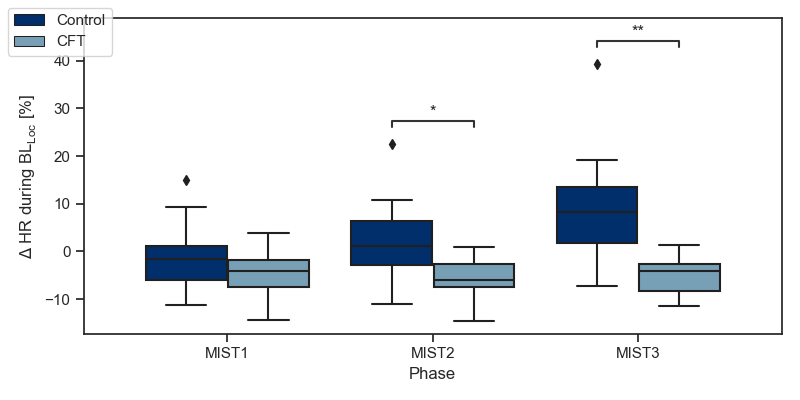

In [17]:
category = ["HR"]
feature = ["HR_Norm"]
subphase = ["BL"]

hr_plot = dataset.get_subset(subphase=subphase).heart_rate
hr_plot = multi_xs(hr_plot, feature, level="type")

stats_data = stats.results_cat("posthoc").loc[category, feature, subphase]
box_pairs, pvalues = stats.sig_brackets(stats_data, stats_effect_type="interaction", plot_type="multi", x="phase")

fig, ax = plt.subplots()
bp.plotting.feature_boxplot(
    data=hr_plot.reset_index(),
    x="phase",
    y="data",
    hue="condition",
    hue_order=hue_order,
    stats_kwargs={"box_pairs": box_pairs, "pvalues": pvalues, "verbose": 0},
    legend_loc="upper left",
    ax=ax,
)

ax.set_xlabel("Phase")
ax.set_ylabel("$\Delta$ HR during $BL_{Loc}$ [%]")

fig.tight_layout()

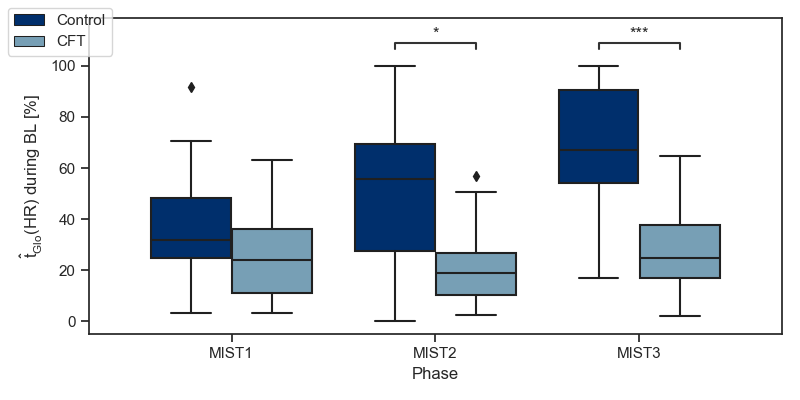

In [18]:
category = ["Time_BL_Glo"]
feature = ["HR"]
subphase = ["BL"]

hr_plot = dataset.get_subset(subphase=subphase).time_above_baseline
hr_plot = multi_xs(hr_plot, feature, level="type")


stats_data = stats.results_cat("posthoc").loc[category, feature, subphase, :]
box_pairs, pvalues = stats.sig_brackets(stats_data, stats_effect_type="interaction", plot_type="multi", x="phase")

fig, ax = plt.subplots()
bp.plotting.feature_boxplot(
    data=hr_plot.reset_index(),
    x="phase",
    y="data",
    hue="condition",
    hue_order=hue_order,
    stats_kwargs={"box_pairs": box_pairs, "pvalues": pvalues, "verbose": 0},
    legend_loc="upper left",
    ax=ax,
)

ax.set_xlabel("Phase")
ax.set_ylabel("$\hat{t}_{Glo}(HR)$ during BL [%]")

fig.tight_layout()

## Supplementary Information

### Response to the MIST (BL-AT, both Conditions)

In [19]:
display(Markdown("#### Prepare Data"))

subphases = ["BL", "AT"]
conditions = ["Control", "CFT"]
measures = ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]

hr_analysis = dataset.get_subset(condition=conditions, subphase=subphases).hr_hrv
hr_analysis = multi_xs(hr_analysis, measures, level="type")
display(hr_analysis.head())

################################################################
display(Markdown("#### Statistics"))

steps = [("prep", "normality"), ("test", "pairwise_tests")]
params = {
    "dv": "data",
    "within": "subphase",
    "subject": "subject",
    "groupby": ["condition", "type", "phase"],
    "multicomp": {"levels": "phase"},
}

stats = bp.stats.StatsPipeline(steps, params)
stats.apply(hr_analysis)

stats.export_statistics(stats_path.joinpath("stats_hrv_response_bl_at_control_cft.xlsx"))
stats.display_results(prep=False)

################################################################
display(Markdown("##### Latex Output"))

index_rename_map = {"HR_Norm": "$\Delta HR$", "HRV_RMSSD": "RMSSD", "HRV_pNN50": "pRR50"}

index_value_order = {"type": ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]}

caption = "HR(V) responses to AT. \
Paired t-tests were performed between BL and AT subphases for each condition and each individual MIST phase, respectively."

df_latex = stats.results_to_latex_table(
    "pairwise_tests",
    unstack_levels="phase",
    index_kws={
        "index_value_order": index_value_order,
        "index_rename_map": index_rename_map,
        "index_level_names_tex": ["Condition", "Measure", "A", "B"],
    },
    caption=caption,
    label="tab:hrv_response_bl_at_control_cft",
    collapse_dof=False,
    show_a_b=True,
    position="h",
)

for path in [tex_path, paper_tex_path]:
    if path is not None:
        path.joinpath("tab_hrv_response_bl_at_control_cft.tex").open(mode="w+").write(df_latex)
print(df_latex)

#### Prepare Data

data
condition subject phase subphase category type                
CFT       Vp01    MIST1 AT       HR       HR_Norm    -4.866102
                                 HRV      HRV_RMSSD  32.343869
                                          HRV_pNN50  14.754098
                        BL       HR       HR_Norm    -4.845864
                                 HRV      HRV_RMSSD  23.746673

#### Statistics

<font size="3"><b> Overview </b></font>

,dv,within,subject,groupby,multicomp
parameter,data,subphase,subject,"['condition', 'type', 'phase']",{'levels': 'phase'}


,prep,test
parameter,normality,pairwise_tests


<font size="3"><b> Statistical Tests </b></font>

**Pairwise Tests**

Contrast   A   B  Paired  Parametric       T  \
condition type      phase                                                   
CFT       HRV_RMSSD MIST1 0  subphase  AT  BL    True        True  2.0577   
                    MIST2 0  subphase  AT  BL    True        True -1.4039   
                    MIST3 0  subphase  AT  BL    True        True -3.9109   
          HRV_pNN50 MIST1 0  subphase  AT  BL    True        True  2.3154   
                    MIST2 0  subphase  AT  BL    True        True -1.0290   
                    MIST3 0  subphase  AT  BL    True        True -2.7540   
          HR_Norm   MIST1 0  subphase  AT  BL    True        True  0.8034   
                    MIST2 0  subphase  AT  BL    True        True  4.0857   
                    MIST3 0  subphase  AT  BL    True        True  6.4911   
Control   HRV_RMSSD MIST1 0  subphase  AT  BL    True        True -1.2899   
                    MIST2 0  subphase  AT  BL    True        True -3.1026   
                    MIST3 0  subphase  AT  BL    True        True -1.9357   
          HRV_pNN50 MIST1 0  subphase  AT  BL    True        True -0.7235   
                    MIST2 0  subphase  AT  BL    True        True -2.7398   
                    MIST3 0  subphase  AT  BL    True        True -1.1772   
          HR_Norm   MIST1 0  subphase  AT  BL    True        True  3.3113   
                    MIST2 0  subphase  AT  BL    True        True  4.1992   
                    MIST3 0  subphase  AT  BL    True        True  3.8499   

                              dof alternative   p-unc     BF10  hedges  p-corr  
condition type      phase                                                       
CFT       HRV_RMSSD MIST1 0  11.0   two-sided  0.0641    1.373  0.4234  0.1923  
                    MIST2 0  11.0   two-sided  0.1879    0.634 -0.2151  0.5637  
                    MIST3 0  11.0   two-sided  0.0024   18.985 -0.4607  0.0072  
          HRV_pNN50 MIST1 0  11.0   two-sided  0.0409    1.935  0.4752  0.1227  
                    MIST2 0  11.0   two-sided  0.3256    0.447 -0.2161  0.9768  
                    MIST3 0  11.0   two-sided  0.0188    3.568 -0.3702  0.0564  
          HR_Norm   MIST1 0  11.0   two-sided  0.4387    0.378  0.2507  1.0000  
                    MIST2 0  11.0   two-sided  0.0018   24.382  1.3587  0.0054  
                    MIST3 0  11.0   two-sided  0.0000  579.528  1.8857  0.0000  
Control   HRV_RMSSD MIST1 0  12.0   two-sided  0.2214    0.552 -0.2024  0.6642  
                    MIST2 0  12.0   two-sided  0.0091    6.231 -0.5338  0.0273  
                    MIST3 0  12.0   two-sided  0.0768    1.166 -0.3515  0.2304  
          HRV_pNN50 MIST1 0  12.0   two-sided  0.4833    0.349 -0.0518  1.0000  
                    MIST2 0  12.0   two-sided  0.0179    3.612 -0.4735  0.0537  
                    MIST3 0  12.0   two-sided  0.2619    0.495 -0.2578  0.7857  
          HR_Norm   MIST1 0  12.0   two-sided  0.0062    8.564  0.6553  0.0186  
                    MIST2 0  12.0   two-sided  0.0012   33.143  0.8936  0.0036  
                    MIST3 0  12.0   two-sided  0.0023   19.512  0.7616  0.0069

##### Latex Output

\begin{table}[h]
\centering
\caption{HR(V) responses to AT. Paired t-tests were performed between BL and AT subphases for each condition and each individual MIST phase, respectively.}
\label{tab:hrv_response_bl_at_control_cft}
\sisetup{table-format = <1.3}

\begin{tabular}{llll||SSSS|SSSS|SSSS}
\toprule
                 &                &             &             & \multicolumn{4}{c}{{MIST1}} & \multicolumn{4}{c}{{MIST2}} & \multicolumn{4}{c}{{MIST3}} \\
                 &                &             &             &     {t} & {df} &          {p} & {Hedges' g} &     {t} & {df} &           {p} & {Hedges' g} &     {t} & {df} &             {p} & {Hedges' g} \\
\textit{Condition} & \textit{Measure} & \textit{A} & \textit{B} &         &      &              &             &         &      &               &             &         &      &                 &             \\
\midrule
\textit{CFT} & \textit{$\Delta HR$} & \textit{AT} & \textit{BL} &   0.803 &   11 &  >0.999$^{}$ &       0.251 &   4

/Users/Richer/Documents/PhD/Projects/HealthPsychology/ColdFaceTest/Code/cft_analysis/.venv/lib/python3.8/site-packages/biopsykit/stats/stats.py:795: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  data_latex = data.to_latex(**kwargs)


#### Increase over MIST

In [20]:
display(Markdown("##### Prepare Data"))

measures = ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]
subphases = ["BL", "AT", "FB"]
conditions = ["Control"]

hr_analysis = dataset.get_subset(condition=conditions, subphase=subphases).hr_hrv

# Select data
hr_analysis = multi_xs(hr_analysis, measures, level="type")
display(hr_analysis.head())

#################################################################
display(Markdown("##### Statistics"))

steps = [("prep", "normality"), ("prep", "equal_var"), ("test", "rm_anova"), ("posthoc", "pairwise_tests")]
params = {
    "dv": "data",
    "within": "phase",
    "subject": "subject",
    "groupby": ["subphase", "type"],
    "multicomp": {"levels": False},
}

stats = bp.stats.StatsPipeline(steps, params)
stats.apply(hr_analysis)

stats.export_statistics(stats_path.joinpath("stats_hrv_response_mist_phases.xlsx"))
stats.display_results(prep=True)  # , sig_only="posthoc")

#################################################################
display(Markdown("##### Latex Output"))

caption = "HR(V) measures of the Control condition over the course of the MIST phases. \
Repeated-measurement ANOVAs were performed separately for BL, AT, and FB subphases with MIST phase as within-variable."

index_value_order = {"type": ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"], "subphase": ["BL", "AT", "FB"]}
index_rename_map = {"HR_Norm": "$\Delta HR$", "HRV_RMSSD": "RMSSD", "HRV_pNN50": "pRR50"}

df_latex = stats.results_to_latex_table(
    "rm_anova",
    unstack_levels=["subphase"],
    index_kws={
        "index_value_order": index_value_order,
        "index_rename_map": index_rename_map,
        "index_level_names_tex": ["Measure"],
    },
    caption=caption,
    label="tab:hrv_increase_mist",
    multicolumn_format="c",
    escape=False,
    multirow=True,
)

print(df_latex)

#################################################################

caption = "Posthoc results of HR(V) measures during the MIST. Pairwise t-tests were performed separately \
for BL, AT, and FB subphases between pairs of MIST phases."

index_value_order = {
    "subphase": ["BL", "AT", "FB"],
    # "type": ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]
}

column_value_order = {"type": ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]}
column_rename_map = {"HR_Norm": "$\Delta HR$", "HRV_RMSSD": "RMSSD", "HRV_pNN50": "pRR50"}

df_latex_posthoc = stats.results_to_latex_table(
    "pairwise_ttests",
    unstack_levels=["type"],
    show_a_b=True,
    column_kws={"column_value_order": column_value_order, "column_rename_map": column_rename_map},
    index_kws={
        "index_value_order": index_value_order,
        # "index_rename_map": index_rename_map,
        "index_level_names_tex": ["Subphase", "A", "B"],
    },
    caption=caption,
    label="tab:hrv_increase_mist_posthoc",
    multirow=True,
    collapse_dof=True,
    position="h",
)

print(df_latex_posthoc)

for path in [tex_path, paper_tex_path]:
    if path is not None:
        path.joinpath("tab_hrv_response_mist_phases.tex").open(mode="w+").write(df_latex)
        path.joinpath("tab_hrv_response_mist_phases_posthoc.tex").open(mode="w+").write(df_latex_posthoc)

##### Prepare Data

data
condition subject phase subphase category type                
Control   Vp03    MIST1 AT       HR       HR_Norm     0.275049
                                 HRV      HRV_RMSSD  11.778790
                                          HRV_pNN50   0.242718
                        BL       HR       HR_Norm    -5.230397
                                 HRV      HRV_RMSSD  21.937769

##### Statistics

<font size="3"><b> Overview </b></font>

,dv,within,subject,groupby,multicomp
parameter,data,phase,subject,"['subphase', 'type']",{'levels': False}


,prep,prep,test,posthoc
parameter,normality,equal_var,rm_anova,pairwise_tests


<font size="3"><b> Preparatory Analysis </b></font>

**Test for Normal Distribution**

W    pval  normal
subphase type                                   
AT       HRV_RMSSD MIST1  0.9513  0.6184    True
                   MIST2  0.9496  0.5926    True
                   MIST3  0.9317  0.3590    True
         HRV_pNN50 MIST1  0.9086  0.1754    True
                   MIST2  0.8782  0.0674    True
                   MIST3  0.8372  0.0195   False
         HR_Norm   MIST1  0.9534  0.6503    True
                   MIST2  0.7528  0.0020   False
                   MIST3  0.9204  0.2539    True
BL       HRV_RMSSD MIST1  0.8837  0.0802    True
                   MIST2  0.8520  0.0303   False
                   MIST3  0.9191  0.2436    True
         HRV_pNN50 MIST1  0.9026  0.1454    True
                   MIST2  0.8868  0.0882    True
                   MIST3  0.8326  0.0171   False
         HR_Norm   MIST1  0.9245  0.2883    True
                   MIST2  0.9617  0.7798    True
                   MIST3  0.8944  0.1122    True
FB       HRV_RMSSD MIST1  0.9660  0.8421    True
                   MIST2  0.9711  0.9067    True
                   MIST3  0.9107  0.1877    True
         HRV_pNN50 MIST1  0.9435  0.5043    True
                   MIST2  0.9374  0.4238    True
                   MIST3  0.8558  0.0339   False
         HR_Norm   MIST1  0.9190  0.2430    True
                   MIST2  0.7566  0.0022   False
                   MIST3  0.9212  0.2602    True

**Test for Homoscedasticity (Equal Variances)**

W    pval  equal_var
subphase type                                       
AT       HRV_RMSSD levene  0.1715  0.8431       True
         HRV_pNN50 levene  0.9638  0.3911       True
         HR_Norm   levene  3.3801  0.0452      False
BL       HRV_RMSSD levene  0.1639  0.8495       True
         HRV_pNN50 levene  0.2318  0.7943       True
         HR_Norm   levene  1.2748  0.2918       True
FB       HRV_RMSSD levene  0.0518  0.9495       True
         HRV_pNN50 levene  0.3082  0.7367       True
         HR_Norm   levene  1.2484  0.2991       True

<font size="3"><b> Statistical Tests </b></font>

**Repeated-measurement ANOVA**

Source  ddof1  ddof2       F   p-unc     ng2     eps  \
subphase type                                                               
AT       HRV_RMSSD 0  phase      2     24  8.3585  0.0018  0.0851  0.9129   
         HRV_pNN50 0  phase      2     24  8.1893  0.0019  0.0939  0.8491   
         HR_Norm   0  phase      2     24  9.1600  0.0011  0.2322  0.9646   
BL       HRV_RMSSD 0  phase      2     24  2.4660  0.1062  0.0382  0.9172   
         HRV_pNN50 0  phase      2     24  1.8156  0.1844  0.0298  0.9056   
         HR_Norm   0  phase      2     24  7.9027  0.0023  0.1832  0.9637   
FB       HRV_RMSSD 0  phase      2     24  7.3983  0.0031  0.0499  0.8670   
         HRV_pNN50 0  phase      2     24  1.8550  0.1782  0.0174  0.6301   
         HR_Norm   0  phase      2     24  9.2494  0.0011  0.1647  0.7786   

                      p-GG-corr sphericity  W-spher  p-spher  
subphase type                                                 
AT       HRV_RMSSD 0        NaN        NaN      NaN      NaN  
         HRV_pNN50 0        NaN        NaN      NaN      NaN  
         HR_Norm   0        NaN        NaN      NaN      NaN  
BL       HRV_RMSSD 0        NaN        NaN      NaN      NaN  
         HRV_pNN50 0        NaN        NaN      NaN      NaN  
         HR_Norm   0        NaN        NaN      NaN      NaN  
FB       HRV_RMSSD 0        NaN        NaN      NaN      NaN  
         HRV_pNN50 0     0.1945      False   0.4129   0.0077  
         HR_Norm   0        NaN        NaN      NaN      NaN

<font size="3"><b> Post-Hoc Analysis </b></font>

**Pairwise Tests**

Contrast      A      B  Paired  Parametric       T   dof  \
subphase type                                                                   
AT       HRV_RMSSD 0    phase  MIST1  MIST2    True        True  2.7194  12.0   
                   1    phase  MIST1  MIST3    True        True  3.5877  12.0   
                   2    phase  MIST2  MIST3    True        True  1.3972  12.0   
         HRV_pNN50 0    phase  MIST1  MIST2    True        True  2.8786  12.0   
                   1    phase  MIST1  MIST3    True        True  3.3882  12.0   
                   2    phase  MIST2  MIST3    True        True  0.9337  12.0   
         HR_Norm   0    phase  MIST1  MIST2    True        True -2.8317  12.0   
                   1    phase  MIST1  MIST3    True        True -4.1871  12.0   
                   2    phase  MIST2  MIST3    True        True -1.5710  12.0   
BL       HRV_RMSSD 0    phase  MIST1  MIST2    True        True  0.3171  12.0   
                   1    phase  MIST1  MIST3    True        True  1.8607  12.0   
                   2    phase  MIST2  MIST3    True        True  1.7031  12.0   
         HRV_pNN50 0    phase  MIST1  MIST2    True        True  0.5274  12.0   
                   1    phase  MIST1  MIST3    True        True  1.7678  12.0   
                   2    phase  MIST2  MIST3    True        True  1.2447  12.0   
         HR_Norm   0    phase  MIST1  MIST2    True        True -1.3782  12.0   
                   1    phase  MIST1  MIST3    True        True -4.0193  12.0   
                   2    phase  MIST2  MIST3    True        True -2.3987  12.0   
FB       HRV_RMSSD 0    phase  MIST1  MIST2    True        True  0.8470  12.0   
                   1    phase  MIST1  MIST3    True        True  3.1000  12.0   
                   2    phase  MIST2  MIST3    True        True  3.2918  12.0   
         HRV_pNN50 0    phase  MIST1  MIST2    True        True  0.9734  12.0   
                   1    phase  MIST1  MIST3    True        True  1.4420  12.0   
                   2    phase  MIST2  MIST3    True        True  1.4801  12.0   
         HR_Norm   0    phase  MIST1  MIST2    True        True -1.9363  12.0   
                   1    phase  MIST1  MIST3    True        True -3.5281  12.0   
                   2    phase  MIST2  MIST3    True        True -2.7546  12.0   

                     alternative   p-unc    BF10  hedges  p-corr  
subphase type                                                     
AT       HRV_RMSSD 0   two-sided  0.0186   3.504  0.4796  0.0558  
                   1   two-sided  0.0037  13.071  0.6576  0.0111  
                   2   two-sided  0.1877   0.616  0.2044  0.5631  
         HRV_pNN50 0   two-sided  0.0139   4.443  0.5318  0.0417  
                   1   two-sided  0.0054   9.632  0.6618  0.0162  
                   2   two-sided  0.3689   0.403  0.1446  1.0000  
         HR_Norm   0   two-sided  0.0151   4.141 -0.8920  0.0453  
                   1   two-sided  0.0013  32.546 -1.3317  0.0039  
                   2   two-sided  0.1422   0.746 -0.4142  0.4266  
BL       HRV_RMSSD 0   two-sided  0.7566   0.291  0.0502  1.0000  
                   1   two-sided  0.0875   1.059  0.4388  0.2625  
                   2   two-sided  0.1143   0.871  0.3808  0.3429  
         HRV_pNN50 0   two-sided  0.6075   0.314  0.0902  1.0000  
                   1   two-sided  0.1025   0.943  0.3767  0.3075  
                   2   two-sided  0.2370   0.528  0.3011  0.7110  
         HR_Norm   0   two-sided  0.1933   0.604 -0.4111  0.5799  
                   1   two-sided  0.0017  25.248 -1.0276  0.0051  
                   2   two-sided  0.0336   2.196 -0.6432  0.1008  
FB       HRV_RMSSD 0   two-sided  0.4136   0.378  0.1045  1.0000  
                   1   two-sided  0.0092   6.206  0.5136  0.0276  
                   2   two-sided  0.0064   8.312  0.3832  0.0192  
         HRV_pNN50 0   two-sided  0.3496   0.415  0.1297  1.0000  
                   1   two-sided  0.1749   0.646  0.3004  0.524

##### Latex Output

KeyError: "['np2'] not in index"